In [59]:
# prompt: 마운트

from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install finance-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 1.9 MB/s eta 0:00:00


#라이브러리 임포트

In [3]:
import datetime
import nltk
import pandas as pd
import numpy as np
##import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
#주가데이터 가져오기
import FinanceDataReader as fdr
import yfinance as yf

#모델 라이브러리
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb
from sklearn.svm import SVC

#모델저장 라이브러리
import pickle
import os

In [4]:
df = pd.read_excel('/content/drive/MyDrive/kdt/team_por/전처리_v2/booldf_ff.xlsx')

In [5]:
#df = df.drop(columns=['head_label_count', 'Text_label_count'])

In [6]:
df.shape

(16676, 23)

In [7]:
df.columns

Index(['head', 'Date', 'Text', 'type', 'src', 'Open', 'High', 'Low', 'Close',
       'Adj Close', 'Volume', 'SOXL_Open', 'SOXL_High', 'SOXL_Low',
       'SOXL_Close', 'SOXL_Adj Close', 'SOXL_Volume', 'head_wordcount',
       'Text_wordcount', 'head_label', 'Text_label', 'head_label_count',
       'Text_label_count'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16676 entries, 0 to 16675
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   head              16672 non-null  object 
 1   Date              16676 non-null  object 
 2   Text              16642 non-null  object 
 3   type              16676 non-null  object 
 4   src               16676 non-null  object 
 5   Open              16676 non-null  float64
 6   High              16676 non-null  float64
 7   Low               16676 non-null  float64
 8   Close             16676 non-null  float64
 9   Adj Close         16676 non-null  float64
 10  Volume            16676 non-null  int64  
 11  SOXL_Open         16676 non-null  float64
 12  SOXL_High         16676 non-null  float64
 13  SOXL_Low          16676 non-null  float64
 14  SOXL_Close        16676 non-null  float64
 15  SOXL_Adj Close    16676 non-null  float64
 16  SOXL_Volume       16676 non-null  int64 

In [9]:
df=df.dropna()

In [10]:
df.isnull().sum()

head                0
Date                0
Text                0
type                0
src                 0
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
SOXL_Open           0
SOXL_High           0
SOXL_Low            0
SOXL_Close          0
SOXL_Adj Close      0
SOXL_Volume         0
head_wordcount      0
Text_wordcount      0
head_label          0
Text_label          0
head_label_count    0
Text_label_count    0
dtype: int64

# type과 src 고윳값 출력

In [11]:
df['type'] = df['type'].str.replace('$', '', regex=False)

In [12]:
df.type.unique()

array(['TSMC', 'ON', 'ASML', 'NVDA', 'AVGO', 'INTC', 'ENTG', 'NXPI', 'MU',
       'TXN', 'MCHP', 'MPWR', 'MRVL', 'QCOM', 'AMD', 'ACLS', 'ASX',
       'KLAC', 'LSCC', 'MKSI', 'QRVO', 'RMBS', 'STM', 'SWKS', 'UMC',
       'WOLF', 'ADI', 'AMAT', 'LRCX', 'TER'], dtype=object)

In [13]:
df.src.unique()

array(['reddit', 'investing', 'naver'], dtype=object)

In [14]:
df = df[df['type'] != "TER"]
df = df[df['src'] != "naver"]

#주가데아턱 가져오기

In [15]:
import FinanceDataReader as fdr

# SOXL 데이터 불러오기
df_soxl = fdr.DataReader('SOXL','2023-05-19')

In [16]:
df_soxl['Adj Close Change %'] = df_soxl['Adj Close'].pct_change() * 100

In [17]:
df_soxl['Next Adj Close'] = df_soxl['Adj Close'].shift(-1)
df_soxl['Change Rate'] = ((df_soxl['Next Adj Close'] - df_soxl['Adj Close']) / df_soxl['Adj Close']) * 100


#종가 변동량을 통한 정답값 만들기

In [18]:
def trading_signal(value):
    if value > 8:
        return 4
    elif value > 2:
        return 3
    elif value >= -2 and value <= 2:
        return 2
    elif value >-8:
        return 1
    else:
        return 0

# 'Adj Close Change %' 열에 함수 적용하여 신호 열 생성
df_soxl['Signal'] = df_soxl['Adj Close Change %'].apply(trading_signal)

#블리쉬 변수 만들기

In [19]:
"""
# trading_signal 함수 정의
def trading_signal(value):
    if value > 8:
        return 4
    elif value > 2:
        return 3
    elif value >= -2 and value <= 2:
        return 2
    elif value > -8:
        return 1
    else:
        return 0

# calculate_bullish 함수 정의
def calculate_bullish(M_buy, M_sell):
    bullish_index = np.log((1 + M_buy) / (1 + M_sell))
    return bullish_index

# classify_bullish_index 함수 정의
def classify_bullish_index(bullish_index):
    if bullish_index > 1.5:
        return 4
    elif bullish_index > 0.5:
        return 3
    elif bullish_index > -0.5:
        return 2
    elif bullish_index > -1.5:
        return 1
    else:
        return 0

# 날짜 변환
df['Date'] = pd.to_datetime(df['Date'])

# 기준 날짜 설정
cutoff_date = datetime.datetime(2024, 1, 19)

df['signal'] = np.nan



# 기준 날짜 이후에는 calculate_bullish 및 classify_bullish_index 함수 사용
for idx, row in df.iterrows():
    if row['Date'] > cutoff_date:
        # 매수 및 매도 신호의 수 계산
        M_buy = (df[(df['Date'] == row['Date'])]['head_label'] == 1).sum() + (df[(df['Date'] == row['Date'])]['Text_label'] == 1).sum()
        M_sell = (df[(df['Date'] == row['Date'])]['head_label'] == -1).sum() + (df[(df['Date'] == row['Date'])]['Text_label'] == -1).sum()

        bullish_index = calculate_bullish(M_buy, M_sell)
        df.at[idx, 'signal'] = classify_bullish_index(bullish_index)

"""


"\n# trading_signal 함수 정의\ndef trading_signal(value):\n    if value > 8:\n        return 4\n    elif value > 2:\n        return 3\n    elif value >= -2 and value <= 2:\n        return 2\n    elif value > -8:\n        return 1\n    else:\n        return 0\n\n# calculate_bullish 함수 정의\ndef calculate_bullish(M_buy, M_sell):\n    bullish_index = np.log((1 + M_buy) / (1 + M_sell))\n    return bullish_index\n\n# classify_bullish_index 함수 정의\ndef classify_bullish_index(bullish_index):\n    if bullish_index > 1.5:\n        return 4\n    elif bullish_index > 0.5:\n        return 3\n    elif bullish_index > -0.5:\n        return 2\n    elif bullish_index > -1.5:\n        return 1\n    else:\n        return 0\n\n# 날짜 변환\ndf['Date'] = pd.to_datetime(df['Date'])\n\n# 기준 날짜 설정\ncutoff_date = datetime.datetime(2024, 1, 19)\n\ndf['signal'] = np.nan\n\n\n\n# 기준 날짜 이후에는 calculate_bullish 및 classify_bullish_index 함수 사용\nfor idx, row in df.iterrows():\n    if row['Date'] > cutoff_date:\n        # 매수 및 매도 

In [20]:
df_soxl.Signal.unique()

array([0, 2, 1, 4, 3])

In [21]:
df_soxl.rename(columns=lambda x: 'soxl_' + x if x != 'Date' else x, inplace=True)

In [22]:

df_soxl['soxl_next_Signal'] = df_soxl['soxl_Signal'].shift(1)

In [23]:
df_soxl.head()

,soxl_Open,soxl_High,soxl_Low,soxl_Close,soxl_Adj Close,soxl_Volume,soxl_Adj Close Change %,soxl_Next Adj Close,soxl_Change Rate,soxl_Signal,soxl_next_Signal
Date,,,,,,,,,,,
2023-05-19,17.590000,17.639999,17.059999,17.389999,17.232965,49381700,NaN,17.371702,0.805067,0,NaN
2023-05-22,16.920000,17.719999,16.889999,17.530001,17.371702,43944400,0.805067,16.767210,-3.479751,2,0.0
2023-05-23,17.200001,17.549999,16.790001,16.920000,16.767210,41287200,-3.479751,15.885247,-5.260046,1,2.0
2023-05-24,15.890000,16.230000,15.490000,16.030001,15.885247,87475800,-5.260046,18.977072,19.463500,1,1.0
2023-05-25,18.160000,19.389999,17.629999,19.150000,18.977072,124768700,19.463500,22.673389,19.477805,4,1.0


#df와 df_soxl을 Date기준으로 함치기

In [24]:
# 겹치는 컬럼 제거
df_soxl.drop(columns=['soxl_Adj Close Change %','soxl_Next Adj Close','soxl_Change Rate'], inplace=True)

In [25]:
df['Date'] = pd.to_datetime(df['Date'])

In [26]:
merged_df = pd.merge(df, df_soxl, on='Date')
merged_df

,head,Date,Text,type,src,Open,High,Low,Close,Adj Close,...,head_label_count,Text_label_count,soxl_Open,soxl_High,soxl_Low,soxl_Close,soxl_Adj Close,soxl_Volume,soxl_Signal,soxl_next_Signal
0,TSMC soon to the moon,2024-04-02,20% oh I remember the optimize last month....b...,TSMC,reddit,172.350006,172.350006,169.600006,170.360001,169.140930,...,-153,-47,45.830002,46.160000,44.380001,45.880001,45.751553,57411500,1,3.0
1,TSMC soon to the moon,2024-04-02,Right there with you man....that 03/08 on TSMC...,TSMC,reddit,172.350006,172.350006,169.600006,170.360001,169.140930,...,-153,-47,45.830002,46.160000,44.380001,45.880001,45.751553,57411500,1,3.0
2,TSMC soon to the moon,2024-04-02,We ride at dawn,TSMC,reddit,172.350006,172.350006,169.600006,170.360001,169.140930,...,-153,-47,45.830002,46.160000,44.380001,45.880001,45.751553,57411500,1,3.0
3,TSMC soon to the moon,2024-04-02,"Not a prediction, but $150 could be in the sta...",TSMC,reddit,172.350006,172.350006,169.600006,170.360001,169.140930,...,-153,-47,45.830002,46.160000,44.380001,45.880001,45.751553,57411500,1,3.0
4,TSMC soon to the moon,2024-04-02,I have $197 as my next target in the big picture.,TSMC,reddit,172.350006,172.350006,169.600006,170.360001,169.140930,...,-153,-47,45.830002,46.160000,44.380001,45.880001,45.751553,57411500,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15619,AMDnew CPU hits 132fps in Fortnite without a g...,2024-01-29,It is possible to run seperate processes on th...,AMD,reddit,178.770004,178.889999,174.399994,177.830002,177.830002,...,26,-2,34.230000,35.130001,33.509998,35.040001,34.913151,54398800,3,0.0
15620,AMDnew CPU hits 132fps in Fortnite without a g...,2024-01-29,Can someone explain what is ment by an extra C...,AMD,reddit,178.770004,178.889999,174.399994,177.830002,177.830002,...,26,-2,34.230000,35.130001,33.509998,35.040001,34.913151,54398800,3,0.0
15621,AMDnew CPU hits 132fps in Fortnite without a g...,2024-01-29,it comes with a stock cooler that keeps it coo...,AMD,reddit,178.770004,178.889999,174.399994,177.830002,177.830002,...,26,-2,34.230000,35.130001,33.509998,35.040001,34.913151,54398800,3,0.0
15622,AMDnew CPU hits 132fps in Fortnite without a g...,2024-01-29,Ie just using the stock cooler in the box,AMD,reddit,178.770004,178.889999,174.399994,177.830002,177.830002,...,26,-2,34.230000,35.130001,33.509998,35.040001,34.913151,54398800,3,0.0


In [27]:
df= merged_df.copy()

In [28]:
df = df.drop(columns=['SOXL_Open', 'SOXL_High', 'SOXL_Low', 'SOXL_Close', 'SOXL_Adj Close', 'SOXL_Volume'])


In [29]:
17+8

25

In [30]:
df.shape

(15624, 25)

In [31]:
df.columns

Index(['head', 'Date', 'Text', 'type', 'src', 'Open', 'High', 'Low', 'Close',
       'Adj Close', 'Volume', 'head_wordcount', 'Text_wordcount', 'head_label',
       'Text_label', 'head_label_count', 'Text_label_count', 'soxl_Open',
       'soxl_High', 'soxl_Low', 'soxl_Close', 'soxl_Adj Close', 'soxl_Volume',
       'soxl_Signal', 'soxl_next_Signal'],
      dtype='object')

#날짜 추출하기

In [32]:
# 'Date' 컬럼에서 날짜 추출
df['Day'] = df['Date'].dt.day

# 'Date' 컬럼에서 월 추출
df['Month'] = df['Date'].dt.month

# 'Date' 컬럼에서 요일 추출
df['Day_of_week'] = df['Date'].dt.dayofweek

# 'Date' 컬럼에서 주(년 중 몇 번째 주인지) 추출
df['Week_of_year'] = df['Date'].dt.isocalendar().week


#원핫인코딩

In [33]:
#df.drop(columns=['Close','SOXL_Close'], inplace=True)

In [34]:
df.shape

(15624, 29)

In [35]:
df.columns

Index(['head', 'Date', 'Text', 'type', 'src', 'Open', 'High', 'Low', 'Close',
       'Adj Close', 'Volume', 'head_wordcount', 'Text_wordcount', 'head_label',
       'Text_label', 'head_label_count', 'Text_label_count', 'soxl_Open',
       'soxl_High', 'soxl_Low', 'soxl_Close', 'soxl_Adj Close', 'soxl_Volume',
       'soxl_Signal', 'soxl_next_Signal', 'Day', 'Month', 'Day_of_week',
       'Week_of_year'],
      dtype='object')

##src

In [36]:
df_onehot = pd.get_dummies(df, columns=['src','type'])

# 기존의 src 컬럼 제거
df.drop(columns=['src','type'], inplace=True)

# 원본 DataFrame에 다시 합치기
df = pd.concat([df, df_onehot], axis=1)
# 겹치는 컬럼 제거
df = df.loc[:, ~df.columns.duplicated()]

In [37]:
df.shape

(15624, 58)

In [38]:
df=df.dropna()
df.shape

(15624, 58)

#word2vec 진행

In [39]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

##head word2vec

In [40]:
import pandas as pd
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

df['head'] = df['head'].astype(str)
df['tokens'] = df['head'].apply(word_tokenize)

# Word2Vec 모델 학습
model = Word2Vec(sentences=df['tokens'], vector_size=50, window=5, min_count=1, workers=4)

In [41]:
def vectorize_headline(tokens, model):
    # 토큰이 모델에 있는 경우에만 벡터 가져오기
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(vectors) > 0:
        # 벡터들의 평균 계산
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 각 헤드라인을 벡터로 변환
df['headline_vector'] = df['tokens'].apply(lambda tokens: vectorize_headline(tokens, model))

# 벡터를 개별 열로 변환
vector_size = model.vector_size
vector_columns = [f'vector_{i}' for i in range(vector_size)]
vector_df = pd.DataFrame(df['headline_vector'].tolist(), columns=vector_columns)

df = pd.concat([df, vector_df], axis=1)

## text의 word2vec 진행하기

In [42]:
df['Text'] = df['Text'].astype(str)
df['tokens'] = df['Text'].apply(word_tokenize)

# Word2Vec 모델 학습
model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

In [43]:
df['headline_vector'] = df['tokens'].apply(lambda tokens: vectorize_headline(tokens, model))

# 벡터를 개별 열로 변환
vector_size = model.vector_size
vector_columns = [f'vector_Text_{i}' for i in range(vector_size)]
vector_df = pd.DataFrame(df['headline_vector'].tolist(), columns=vector_columns)

# 기존 데이터프레임과 벡터 데이터프레임 결합
df = pd.concat([df, vector_df], axis=1)

#학습에 사용하지 못하는 컬럼 제거

In [44]:
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, str) or isinstance(x, list)).all():
        df.drop(columns=[col], inplace=True)


In [45]:
signal_column = df.pop('soxl_Signal')
df.insert(0, 'soxl_Signal', signal_column)

In [46]:
df.shape

(15624, 207)

In [47]:
df = df.dropna()

In [48]:
split_date = pd.to_datetime('2024-01-23')
train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]

In [49]:
train_data = train_data.drop(columns=['headline_vector'])
test_data  = test_data .drop(columns=['headline_vector'])
train_data = train_data.drop(columns=['Date'])
test_data  = test_data .drop(columns=['Date'])

In [50]:
columns_list = train_data.columns[1:].tolist()

#학습할 컬럼 지정

In [51]:
columns_list = train_data.columns[1:].tolist()

In [52]:
df = df.dropna()

In [53]:
X = df[columns_list]

y = df[['soxl_Signal']].values.ravel()

##학습할 컬럼 지정
X_train_cat = train_data.loc[:, columns_list]
X_test_cat = test_data.loc[:, columns_list]


In [54]:
def custom_accuracy(y_true, y_pred):
    # 예측과 실제 값의 차이를 계산
    differences = np.abs(y_true - y_pred)

    # 3인 경우에는 정확하게 일치해야 함
    exact_matches = (y_true == 2) & (y_pred == 2)

    # 3이 아닌 경우에는 차이가 1 이하인 경우를 적중으로 간주
    near_matches = (y_true != 2) & (differences <= 1)

    # 적중한 경우를 결합
    accurate_predictions = exact_matches | near_matches

    # 적중한 경우의 비율을 계산하여 반환
    return np.mean(accurate_predictions)

# 커스텀 정확도 계산



In [55]:
df=df.dropna()

In [56]:
X_train_cat.shape

(6629, 204)

#모델학습

In [60]:
xgb_classifier = xgb.XGBClassifier(seed=41)
# train_data와 test_data에서 X와 y를 설정합니다.
X_train_cat = train_data[columns_list].astype(float)
y_train_cat = train_data['soxl_Signal'].astype(int)

X_test_cat = test_data[columns_list].astype(float)
y_test_cat = test_data['soxl_Signal'].astype(int)


# 8개의 모델을 정의합니다.
models = {
   # "Logistic Regression": LogisticRegression(max_iter=2000, random_state=41),
   # "Random Forest Classifier": RandomForestClassifier(random_state=41),
   # "KNN": KNeighborsClassifier(),
   # "Support Vector Classifier": SVC(random_state=41),
   # "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=41),
   # "Decision Tree Classifer": DecisionTreeClassifier(random_state=41),
   # "Bagging": BaggingClassifier(random_state=41),
   # "XGBClassifier Classifier": xgb.XGBClassifier(seed=41)
}
lst=[]
# 각 모델의 정확도를 출력합니다.
for name, model in models.items():

    model.fit(X_train_cat, y_train_cat)
    y_pred = model.predict(X_test_cat)
    lst.append(y_pred)
    accuracy = np.mean(y_pred == y_test_cat)
    # 커스텀 정확도 계산
    accuracy = custom_accuracy( y_test_cat,y_pred)
    print("{} Mean Cross-Validation Accuracy Score: {}".format(name, accuracy))

Gradient Boosting Mean Cross-Validation Accuracy Score: 0.8688160088938299


In [69]:
%matplotlib inline
import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리

!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치
fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정
mpl.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123586 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

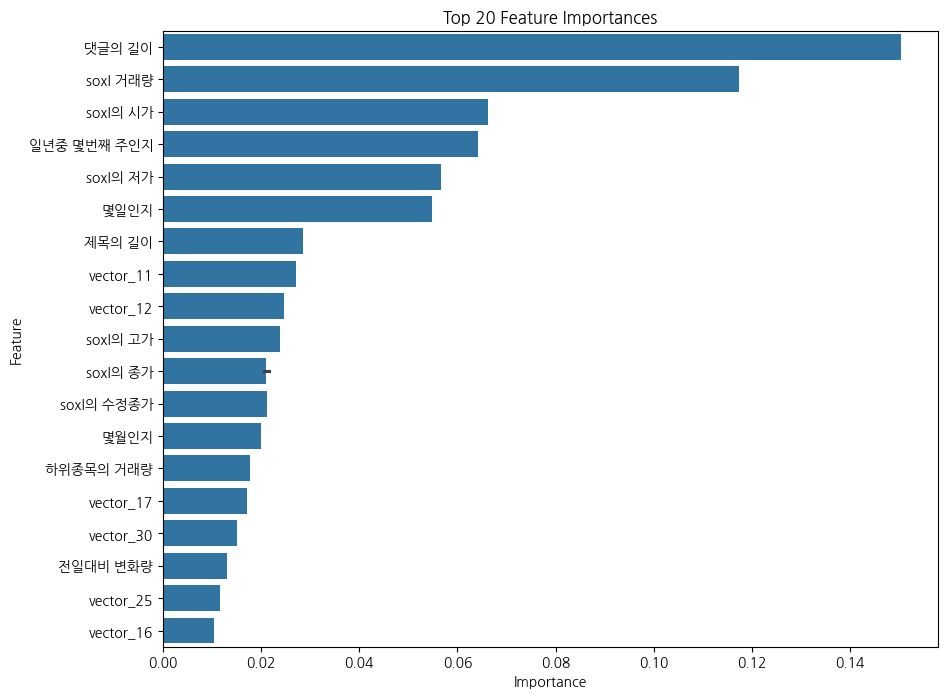

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 모델의 feature importances 가져오기
importances = model.feature_importances_

# feature names 가져오기 (여기서는 X_train_cat이 pandas DataFrame이라고 가정)
feature_names = X_train_cat.columns

# feature importances와 feature names를 데이터프레임으로 만들기
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 중요도 순으로 정렬 후 상위 20개 선택
top_20_features = feature_importances.sort_values(by='Importance', ascending=False).head(20)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y=["댓글의 길이","soxl 거래량","soxl의 시가","일년중 몇번째 주인지","soxl의 저가","몇일인지","제목의 길이","vector_11","vector_12","soxl의 고가","soxl의 종가","soxl의 수정종가","soxl의 종가","몇월인지","하위종목의 거래량","vector_17","vector_30","전일대비 변화량","vector_25","vector_16"], data=top_20_features, orient='h')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
df_to_lst = pd.DataFrame(lst[0])